In [ ]:
!pip install -q transformers flax==0.3.5
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git  # VQGAN model in JAX
 # Model files
!pip install -q git+https://github.com/borisdayma/dalle-mini.git@26651ddd777f73dd18dade8bf543a6a8732d3669


     |████████████████████████████████| 3.4 MB 12.5 MB/s 
     |████████████████████████████████| 193 kB 53.3 MB/s 
     |████████████████████████████████| 126 kB 51.1 MB/s 
     |████████████████████████████████| 596 kB 44.7 MB/s 
     |████████████████████████████████| 895 kB 42.7 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 3.3 MB 35.8 MB/s 
     |████████████████████████████████| 65 kB 2.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 235 kB 13.4 MB/s 
     |████████████████████████████████| 64 kB 2.9 MB/s 


In [ ]:
from dalle_mini.model import CustomFlaxBartForConditionalGeneration
from transformers import BartTokenizer
import jax
import random
from tqdm.notebook import tqdm, trange
from vqgan_jax.modeling_flax_vqgan import VQModel
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, FlaxCLIPModel

import os
import shutil
from google.colab import files

In [ ]:
DALLE_REPO = "flax-community/dalle-mini"
DALLE_COMMIT_ID = "4d34126d0df8bc4a692ae933e3b902a1fa8b6114"
# make sure we use compatible versions
VQGAN_REPO = "flax-community/vqgan_f16_16384"
VQGAN_COMMIT_ID = "90cc46addd2dd8f5be21586a9a23e1b95aa506a9"
# set up model and processor
clip = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/577M [00:00<?, ?B/s]

INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/842k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

In [ ]:
# set up tokenizer and model
tokenizer = BartTokenizer.from_pretrained(DALLE_REPO, revision=DALLE_COMMIT_ID)
model = CustomFlaxBartForConditionalGeneration.from_pretrained(
    DALLE_REPO, revision=DALLE_COMMIT_ID
)
vqgan = VQModel.from_pretrained(VQGAN_REPO, revision=VQGAN_COMMIT_ID)

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/343 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.64G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/290M [00:00<?, ?B/s]

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


In [ ]:
prompt =  "a blue and yellow ball"

# tokenize the prompt
tokenized_prompt = tokenizer(
	prompt, return_tensors="jax", padding="max_length", truncation=True, max_length=128
)


In [ ]:
n_predictions = 10

# create random keys
seed = random.randint(0, 2 ** 32 - 1)
key = jax.random.PRNGKey(seed)
subkeys = jax.random.split(key, num=n_predictions)

In [ ]:

encoded_images = [
	model.generate(**tokenized_prompt, do_sample=True, num_beams=1, prng_key=subkey)
	for subkey in tqdm(subkeys)
]

encoded_images = [img.sequences[..., 1:] for img in encoded_images]

decoded_images = [
	vqgan.decode_code(encoded_image) for encoded_image in tqdm(encoded_images)
]

clipped_images = [img.squeeze().clip(0.0, 1.0) for img in decoded_images]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Prompt: a blue and yellow ball

Score: 0.8122187852859497


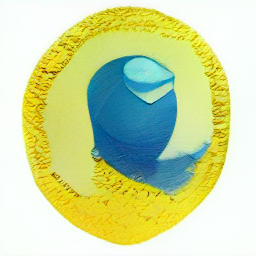


Score: 0.08141447603702545


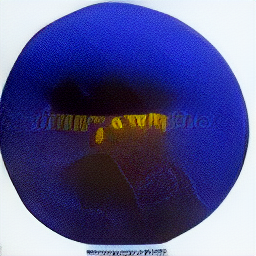


Score: 0.03256288543343544


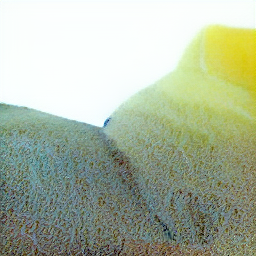


Score: 0.02651148848235607


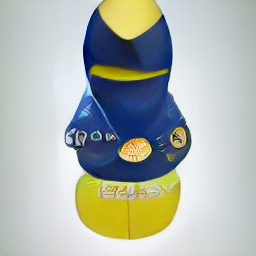


Score: 0.016115983948111534


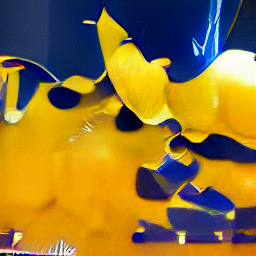


Score: 0.01413651928305626


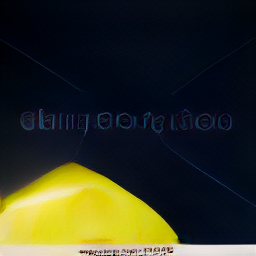


Score: 0.013105727732181549


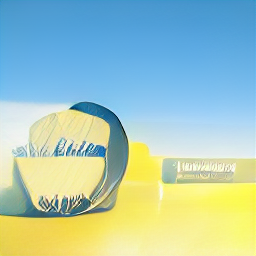


Score: 0.0023718723095953465


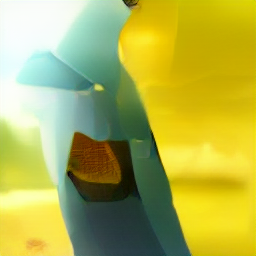


Score: 0.0014918295200914145


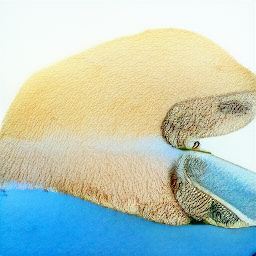


Score: 7.042385550448671e-05


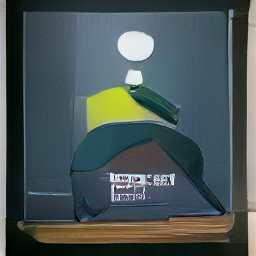

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:


images = [
	Image.fromarray(np.asarray(img * 255, dtype=np.uint8)) for img in clipped_images
]

newpath = str(prompt)
if not os.path.exists(newpath):
    os.makedirs(newpath)




# evaluate scores
inputs = processor(text=prompt, images=images, return_tensors="np")
logits = clip(**inputs).logits_per_image
scores = jax.nn.softmax(logits, axis=0).squeeze()  # normalize and sum all scores to 1



for i,j in enumerate(images):

  # Take the score as a good format for file naming
  t = np.asarray(scores[i])
  score_str = str(t)
  score_str = score_str[:5]
  if score_str[0]!="0":
    score_str = "0.000"
  score_str = score_str[:5]

  file_name = score_str+" "+prompt + " " +str(i)+".jpeg"
  j.save(file_name)
  shutil.move(file_name, prompt+"/"+file_name)


# # rank images by score
print(f"Prompt: {prompt}\n")
for idx in scores.argsort()[::-1]:
	print(f"Score: {scores[idx]}")
	display(images[idx])
	print()
 


shutil.make_archive(prompt, 'zip', "/content/"+prompt)
files.download("/content/"+prompt+".zip")

In [ ]:

shutil.make_archive(prompt, 'zip', "/content/"+prompt)
files.download("/content/"+prompt+".zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
shutil.move("0.006 a picture of a ball 2.jpeg", "a picture of a ball/0.006 a picture of a ball 2.jpeg")


'a picture of a ball/0.006 a picture of a ball 2.jpeg'

In [ ]:

shutil.make_archive("a circle", 'zip', "/content/"+"a circle")
files.download("/content/"+"a circle"+".zip")

FileNotFoundError: ignored